**Imports**

In [2]:
from __future__ import division
import scipy.constants as const
import scipy
from scipy.io import wavfile
from IPython.core.display import HTML
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal 
%matplotlib inline

**Constants, defaults, etc.**

Sampling rate set to 44.1KHz

Number of unique notes set to 88 (source: wikipedia)

In [19]:
rate = 44100 #44.1 khz
key2freq = lambda n : 2 ** ((n+1-49)/12) * 440 # convert a piano key n to a frequency in Hz
num_notes = 88

# Bi-directional mapping between keys and frequencies
key2frequency = {i : key2freq(i) for i in range(88)}
frequency2key = {key2frequency[key] : key for key in key2frequency}

** Output **

Playing the actual music

In [4]:
# this is a wrapper that take a filename and publish an html <audio> tag to listen to it
def wavPlayer(filepath):
    src = """
    <head>
    <meta http-equiv="Content-Type" content="text/html; charset=utf-8">
    <title>Simple Test</title>
    </head>
    <body>
    <audio controls="controls" style="width:600px" >
      <source src="files/%s" type="audio/wav" />
      Your browser does not support the audio element.
    </audio>
    </body>
    """%(filepath)
    display(HTML(src))
    
def playMusic(title, rate, music):
    # write the file on disk, and show in in a Html 5 audio player
    music_wav = music * 2**13
    wavfile.write(title + '.wav', rate, music_wav.astype(np.int16))
    wavPlayer(title + '.wav')

** LOGIC **

Implementing the Markov model

In [21]:
def song_from_notes(notes):
    """Converts a list of notes into a playable song"""
    
    note_duration = 0.5 # per key, in sec
    music_duration = note_duration * len(notes)
    time = np.linspace(0, music_duration, num=rate*music_duration) # indices for 0-16 secs spaced apart by 1/44100
    song = np.zeros(len(time))

    sinwave = lambda f,t : np.sin(2*np.pi*f*t) # generate a sinusoid of frequency f Hz over time t

    idx_note = 0
    for note in notes:
        if note: # if note == 0, skip.
            freq = key2freq(note) # frequency of each note
            song[idx_note*rate*note_duration : (idx_note+1)*rate*note_duration-1] = \
                    sinwave(freq,
                            time[idx_note*rate*note_duration : (idx_note+1)*rate*note_duration-1 ] 
                            ) #generates the sinusoids for the song, in .5 sec intervals
        idx_note += 1
        
    return song

In [6]:
def notes_from_wav(wav_file):
    """Converts a wav file to a list of notes"""
    
    # TODO
    notes = []
    rate, track1_data = wavfile.read("/Users/Ujval/Documents/berkeley/ee126/proj/markovian-music/fur_elise.wav") #import song
    
    return notes


In [45]:
def stochastic_matrix(*note_lists, **kwargs):
    """Calculates the stochastic matrix from all of the note lists
    and for a Markov model of the given degree"""
    
    degree = kwargs['degree']
    matrix = np.zeros((num_notes**degree,num_notes**degree))
    
    for notes in note_lists:
        for i in range(len(notes)):
            
            curr_note_sequence = notes[i:i+degree]
            # Calculate the index as a transformation from base-88 to base-10
            curr_seq_index = notes2index(curr_note_sequence)
            
            print curr_note_sequence, " with index ", curr_seq_index
            
            if i < len(notes)-degree:
                next_note = notes[i+degree]
                next_note_sequence = curr_note_sequence[1:] + [next_note]
                next_seq_index = notes2index(next_note_sequence)
                print next_note_sequence, " (next) with index ", next_seq_index
            else:
                next_note = None
            if next_note:
                matrix[curr_seq_index][next_seq_index] += 1
                
    return normalize(matrix)

def normalize(matrix):
    """Normalizes matrix rows"""
    
    l = len(matrix)
    totals = matrix.sum(axis=1)
    new_matrix = np.array([])
    for i in range(l):
        if totals[i] == 0:
            new_matrix = np.append(new_matrix, notes[i])
            continue
        new_row = [el/totals[i] for el in np.nditer(notes[i])]
        new_matrix = np.append(new_matrix, new_row)
    return new_matrix.reshape(l,l)
    
def notes2index(note_sequence):
    """Calculates the index of the stochastic matrix for the given sequence of notes,
    generalized to n notes"""
    return sum([note_sequence[i]*(88**i) for i in range(len(note_sequence)-1, -1, -1)])

notes = [47, 47, 49, 49, 47, 47]
test = stochastic_matrix(notes, degree=2)


[47, 47]  with index  4183
[47, 49]  (next) with index  4359
[47, 49]  with index  4359
[49, 49]  (next) with index  4361
[49, 49]  with index  4361
[49, 47]  (next) with index  4185
[49, 47]  with index  4185
[47, 47]  (next) with index  4183
[47, 47]  with index  4183
[47]  with index  47


IndexError: list index out of range

In [8]:
def random_walk(stoch_matrix, size):
    initial_note = 47
    distribution = stoch_matrix[initial_note]
    result = np.array([initial_note])
    for i in range(1, size):
        x = np.sum(distribution)
        if not x:
            next_val = np.random.choice(np.arange(0,88))
            result = np.append(result, next_val)
            distribution = stoch_matrix[next_val]
        else:
            next_val = np.random.choice(np.arange(0,88), 1, p = distribution)
            result = np.append(result, next_val)
            distribution = stoch_matrix[next_val[0]]
    return result

**MAIN**

Putting everything together

In [11]:
# Get notes from wav
notes = notes_from_wav(wavfile)
notes = [np.random.choice(range(88)) for i in range(100)]
notes = [47, 47, 49, 49, 47, 47, 44, 44, 47, 47, 44, 44, 42, 42, 42, 0, 47, 47, 49, 49, 47, 47, 44, 44, 47, 44, 42, 44, 40, 40, 40, 0]# Calculate stochastic matrix
notes2 = [47, 42, 44, 40, 39, 40, 39]# Calculate stochastic matrix

matrix = stochastic_matrix(1, notes, notes2)

# Create a random walk of notes, starting from a particular note
generated_song_notes = random_walk(matrix, len(notes))

# play song for notes
playMusic("test1", rate, song_from_notes(generated_song_notes))
playMusic("test2", rate, song_from_notes(notes2))

/Users/Ujval/Documents/berkeley/ee126/venv/lib/python2.7/site-packages/ipykernel/__main__.py:15: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


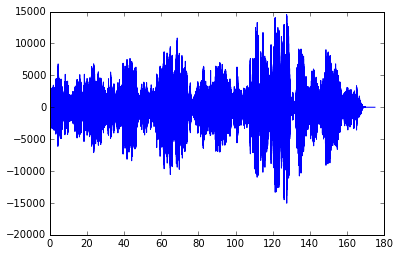

In [29]:
rate, track1_data = wavfile.read("/Users/Ujval/Documents/berkeley/ee126/proj/markovian-music/fur_elise.wav") #import song

flattened = (track1_data[:, 1] + track1_data[:,0])/2
frequencies = abs(np.fft.fft(flattened))

t = np.linspace(0, (len(track1_data)-1)/rate, len(track1_data))
plt.plot(t, flattened)
plt.show()

#playMusic('gymnopedie1_played', rate, data_song1)